# Data Preprocessing and Visualization for BISINDO Sign Language Dataset

This notebook documents the preprocessing and visualization workflow for the BISINDO sign language dataset. Below is a detailed explanation of each step:

## Importing Required Libraries
We start by importing the necessary libraries for data processing, visualization, and file handling. These include `numpy`, `pandas`, `os`, `matplotlib`, `cv2`, and others.

In [29]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import cv2

## Defining Paths
We define the base path for the raw dataset, the processed data directory, and the landmarks directory. These paths are used throughout the notebook for file handling.

In [30]:
BASE_PATH = '../data/raw/BISINDO'
PROCESSED_PATH = '../data/processed'
LANDMARKS_PATH = os.path.join(PROCESSED_PATH, 'landmarks')

## Creating Necessary Directories
We ensure that the directories for processed data and landmarks exist. If they do not exist, they are created.

In [31]:
os.makedirs(PROCESSED_PATH, exist_ok=True)
os.makedirs(LANDMARKS_PATH, exist_ok=True)

## Listing Classes
We list all the classes (signs) available in the dataset by scanning the base directory. This helps us understand the structure of the dataset and the number of classes.

In [32]:
classes = sorted([d for d in os.listdir(BASE_PATH) if os.path.isdir(os.path.join(BASE_PATH, d))])
print(f"Found {len(classes)} classes: {classes}")


Found 6 classes: ['Bertemu', 'Halo', 'Kamu', 'Perkenalkan', 'Saya', 'Senang']


## Processing Landmark Data
For each class, we iterate through the subdirectories and process the `.npy` files containing landmark data. The processed data is saved in the landmarks directory, and metadata is collected for each sample.

In [33]:
data = []
for class_name in tqdm(classes, desc="Processing classes"):
    class_path = os.path.join(BASE_PATH, class_name)
    
    # Process each subfolder (usually representing different people/samples)
    for person_id in os.listdir(class_path):
        person_path = os.path.join(class_path, person_id)
        
        if os.path.isdir(person_path):
            # Process each NPY file in the subfolder
            for file_name in os.listdir(person_path):
                if file_name.endswith('.npy') and not file_name.endswith(':Zone.Identifier'):
                    file_path = os.path.join(person_path, file_name)
                    
                    try:
                        # Load the landmark data
                        landmarks = np.load(file_path)
                        
                        # Create a unique identifier for this sample
                        sample_id = f"{class_name}_{person_id}_{file_name.replace('.npy', '')}"
                        
                        # Save processed landmarks to the landmarks directory
                        output_file = os.path.join(LANDMARKS_PATH, f"{sample_id}.npy")
                        np.save(output_file, landmarks)
                        
                        # Add metadata to our list
                        data.append({
                            'sample_id': sample_id,
                            'class': class_name,
                            'person_id': person_id,
                            'original_file': file_name,
                            'n_frames': landmarks.shape[0] if landmarks.ndim > 1 else 1,
                            'landmark_path': output_file
                        })
                        
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")


Processing classes: 100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


## Creating a Metadata DataFrame
The collected metadata is converted into a Pandas DataFrame for easier analysis and manipulation. This DataFrame contains information such as sample ID, class, person ID, original file name, number of frames, and the path to the processed landmarks.

In [34]:
df = pd.DataFrame(data)
print(f"Total processed samples: {len(df)}")

Total processed samples: 18000



## Saving Metadata
The metadata DataFrame is saved as a CSV file in the processed data directory. This file serves as a reference for the processed dataset.

In [35]:
metadata_path = os.path.join(PROCESSED_PATH, 'metadata.csv')
df.to_csv(metadata_path, index=False)
print(f"Metadata saved to {metadata_path}")

Metadata saved to ../data/processed/metadata.csv



## Class Distribution Analysis
We analyze the distribution of samples across different classes. This helps us understand the balance of the dataset and identify any potential biases.

In [36]:
print("\nSample distribution per class:")
class_counts = df['class'].value_counts().sort_index()
print(class_counts)


Sample distribution per class:
class
Bertemu        3000
Halo           3000
Kamu           3000
Perkenalkan    3000
Saya           3000
Senang         3000
Name: count, dtype: int64



## Visualizing Class Distribution
A bar chart is generated to visualize the number of samples per class. This provides a clear representation of the dataset's class distribution.

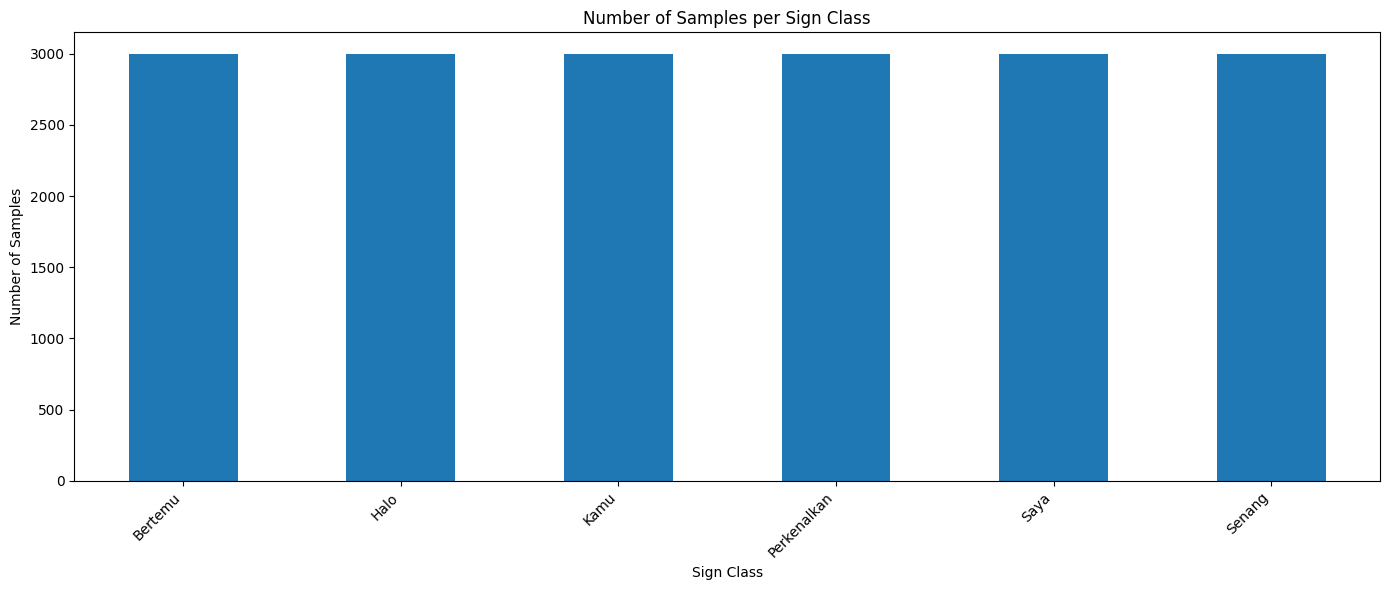

In [37]:
plt.figure(figsize=(14, 6))
class_counts.plot(kind='bar')
plt.title('Number of Samples per Sign Class')
plt.xlabel('Sign Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Frame Statistics
We calculate basic statistics for the number of frames per sample, such as mean, median, and standard deviation. This helps us understand the temporal characteristics of the dataset.

In [38]:
print("\nBasic statistics for number of frames per sample:")
print(df['n_frames'].describe())


Basic statistics for number of frames per sample:
count    18000.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: n_frames, dtype: float64


## Inspecting a Sample
We load and inspect a sample from the processed dataset to verify the correctness of the preprocessing steps. The shape and data type of the sample are printed for validation.

In [39]:
sample_path = df.iloc[0]['landmark_path']
sample_data = np.load(sample_path)
print(f"\nSample data shape: {sample_data.shape}")
print(f"Sample data type: {sample_data.dtype}")


Sample data shape: (126,)
Sample data type: float64



## Visualizing Landmark Data
We visualize the landmark data for a random sample. If the sample contains multiple frames, we display up to three frames. The visualization includes normalized landmark points plotted on a blank image.


Visualizing sample from class: Bertemu


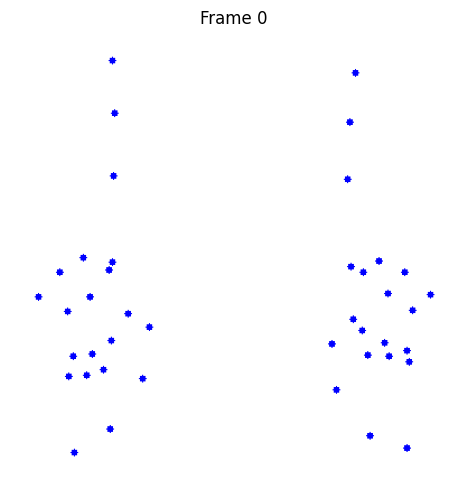

Data preprocessing completed successfully!


In [40]:
try:
    plt.figure(figsize=(15, 5))
    
    # Get a random sample
    sample = df.sample(1).iloc[0]
    print(f"\nVisualizing sample from class: {sample['class']}")
    
    # Load landmark data
    landmarks = np.load(sample['landmark_path'])
    
    # Check if we have multiple frames
    n_frames = min(3, landmarks.shape[0]) if landmarks.ndim > 1 else 1
    
    for i in range(n_frames):
        plt.subplot(1, n_frames, i+1)
        
        # Get landmarks for this frame
        frame_data = landmarks[i] if landmarks.ndim > 1 else landmarks
        
        # Try to interpret the data format - this may need adjustment based on your specific data
        if frame_data.size > 6:  # If we have enough points to represent landmarks
            # Create a blank image
            img = np.ones((400, 400, 3), dtype=np.uint8) * 255
            
            # Reshape if needed and extract x,y coordinates
            if frame_data.ndim > 1:
                points = frame_data[:, :2]  # Assuming first two columns are x,y
            else:
                # If flat array, try to reshape assuming groups of 3 (x,y,z)
                points = frame_data.reshape(-1, 3)[:, :2]
            
            # Normalize to fit in our image
            min_vals = np.min(points, axis=0)
            max_vals = np.max(points, axis=0)
            range_vals = max_vals - min_vals
            normalized_points = (points - min_vals) / range_vals if np.any(range_vals) else points
            
            # Plot points
            for pt in normalized_points:
                x, y = int(pt[0] * 350 + 25), int(pt[1] * 350 + 25)
                cv2.circle(img, (x, y), 3, (0, 0, 255), -1)
            
            plt.imshow(img)
            plt.title(f"Frame {i}")
        else:
            # Just plot the raw values
            plt.plot(frame_data)
            plt.title(f"Raw data for frame {i}")
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not visualize data: {e}")
    print("You may need to adjust the visualization code based on your data format.")

print("Data preprocessing completed successfully!")